In [1]:
import pandas as pd
import os
import glob
import numpy as np
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

combined_hc_data = pd.read_csv('/Users/martinli/Desktop/SZ/combined_hc_data.csv', index_col=0)
combined_uc_data = pd.read_csv('/Users/martinli/Desktop/SZ/combined_uc_data.csv', index_col=0)
combined_full_data = pd.concat([combined_hc_data, combined_uc_data], axis=1)

/var/folders/yv/682pv_nx7q561mgzzkj5sr280000gn/T/ipykernel_26881/1000434228.py:15: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  combined_hc_data = pd.read_csv('/Users/martinli/Desktop/SZ/combined_hc_data.csv', index_col=0)
/var/folders/yv/682pv_nx7q561mgzzkj5sr280000gn/T/ipykernel_26881/1000434228.py:16: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128

In [2]:
i2g = pd.read_csv('/Users/martinli/Desktop/SZ/i2g_df_gene_ppion.csv', index_col=0)
i2g_ppion = i2g[i2g['ppion'] == True]
i2g_initial = i2g[i2g['initial'] == True]
gene_names = set(i2g_initial['gene_name'])
hc_columns = combined_hc_data.columns
uc_columns = combined_uc_data.columns

# 筛选
filtered_hc_data = combined_hc_data.loc[combined_hc_data.index.isin(gene_names)]
filtered_uc_data = combined_uc_data.loc[combined_uc_data.index.isin(gene_names)]
combined_data = pd.concat([filtered_hc_data, filtered_uc_data], axis=1)
combined_data = combined_data.apply(pd.to_numeric, errors='coerce')
combined_data.dropna(axis=0, how='any', inplace=True)
print(combined_data.shape)
print(combined_data.head())
'''
combined_data = pd.concat([combined_hc_data, combined_uc_data], axis=1)
combined_data = combined_data.apply(pd.to_numeric, errors='coerce')
combined_data.dropna(axis=0, how='any', inplace=True)
combined_data.shape
combined_data.head()
'''

(16542, 320)
         GSM2932807  GSM2932808  GSM2932809  GSM2932810  GSM2932811  \
0                                                                     
A1BG         3.2298      7.3417    5.240800    2.555300    1.626500   
A1CF        11.3730     15.5388    6.019300   19.330600   12.206000   
A2ML1        0.1130      0.0100    0.043795    0.011602    0.011105   
A2M         83.9559    121.7395  138.736700   56.322100   33.125700   
A3GALT2      0.0100      0.0100    0.030966    0.039208    0.010000   

         GSM2932812  GSM2932813  GSM2932814  GSM2932815  GSM2932816  ...  \
0                                                                    ...   
A1BG       2.679200    2.790100     2.71550    2.230500     2.40190  ...   
A1CF      12.247100   12.537700    10.86450   15.144000    12.29160  ...   
A2ML1      0.088573    0.048154     0.03113    0.061851     0.16262  ...   
A2M       26.676100   44.366500    65.38850   36.885900    46.43040  ...   
A3GALT2    0.010000    0.010000  

"\ncombined_data = pd.concat([combined_hc_data, combined_uc_data], axis=1)\ncombined_data = combined_data.apply(pd.to_numeric, errors='coerce')\ncombined_data.dropna(axis=0, how='any', inplace=True)\ncombined_data.shape\ncombined_data.head()\n"

In [3]:
# 批次列表
batch = [1 if col.startswith('GSM2') else 2 for col in combined_data.columns]

# 分离
batch1_data_before = combined_data.loc[:, [col for col, b in zip(combined_data.columns, batch) if b == 1]]
batch2_data_before = combined_data.loc[:, [col for col, b in zip(combined_data.columns, batch) if b == 2]]
#batch1_data = combined_full_data.loc[:, [col for col, b in zip(combined_data.columns, batch) if b == 1]]
#batch2_data = combined_full_data.loc[:, [col for col, b in zip(combined_data.columns, batch) if b == 2]]
print("Batch 1 data shape:", batch1_data_before.shape)
print("Batch 2 data shape:", batch2_data_before.shape)

plot_data = combined_data.T.copy()
plot_data['Batch'] = batch

Batch 1 data shape: (16542, 222)
Batch 2 data shape: (16542, 98)


In [4]:
# Separate data by batch and type (HC/UC)
batch1_hc_data = batch1_data_before.loc[:, batch1_data_before.columns.isin(hc_columns)]
batch1_uc_data = batch1_data_before.loc[:, batch1_data_before.columns.isin(uc_columns)]
batch2_hc_data = batch2_data_before.loc[:, batch2_data_before.columns.isin(hc_columns)]
batch2_uc_data = batch2_data_before.loc[:, batch2_data_before.columns.isin(uc_columns)]

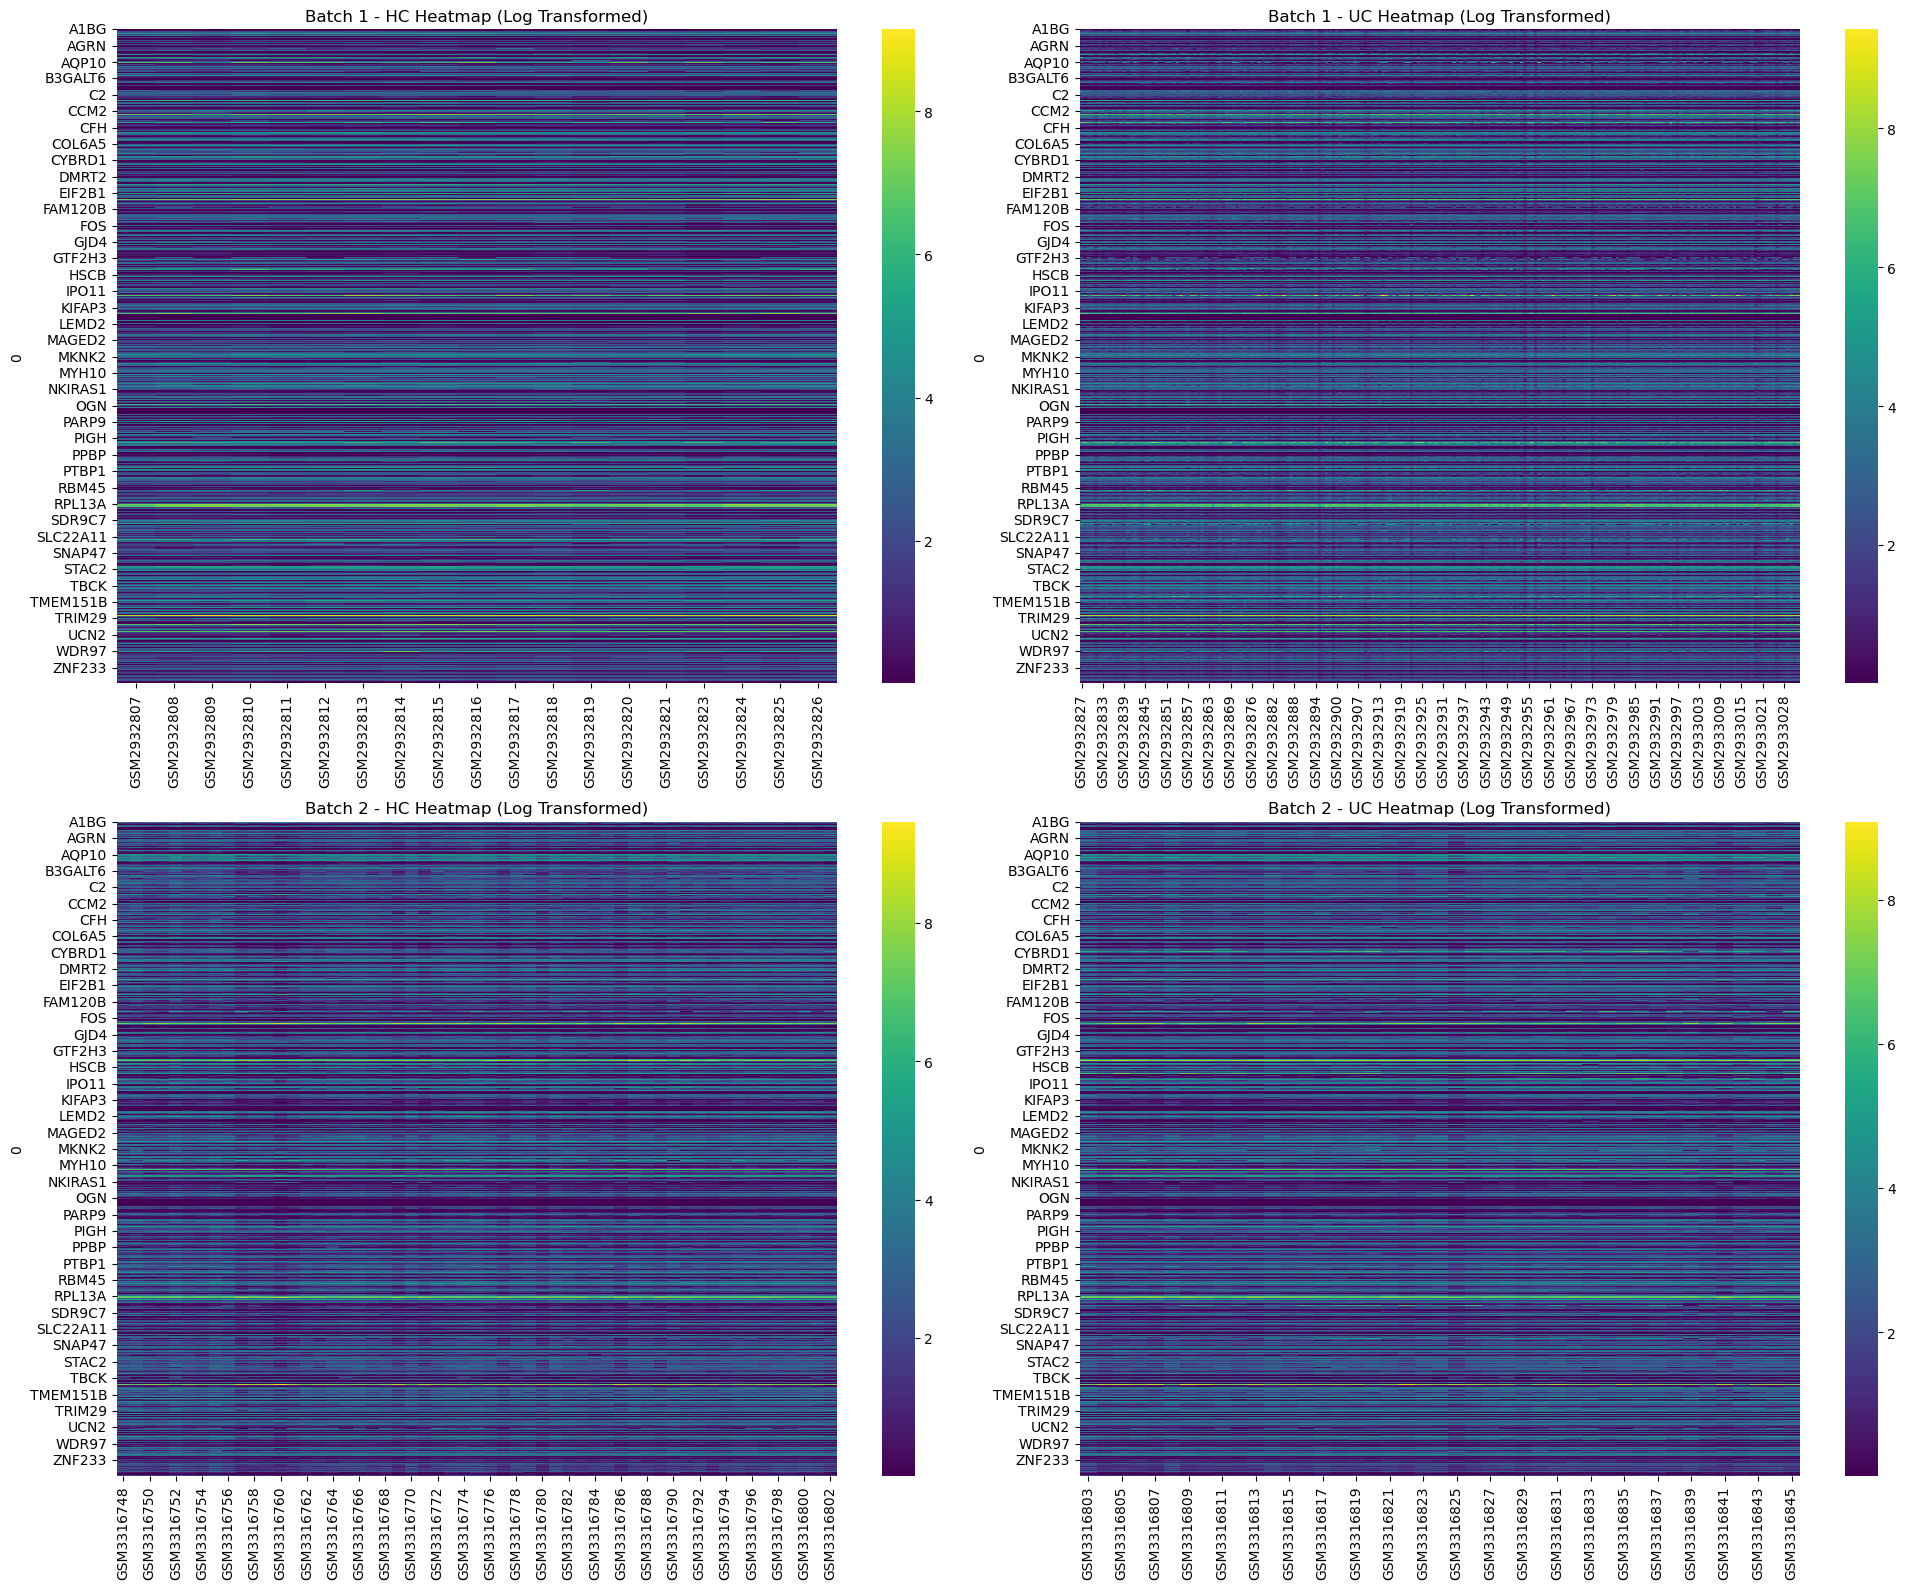

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(20, 16))
sns.heatmap(log_batch1_hc_data, cmap='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Batch 1 - HC Heatmap (Log Transformed)')
sns.heatmap(log_batch1_uc_data, cmap='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Batch 1 - UC Heatmap (Log Transformed)')
sns.heatmap(log_batch2_hc_data, cmap='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Batch 2 - HC Heatmap (Log Transformed)')
sns.heatmap(log_batch2_uc_data, cmap='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Batch 2 - UC Heatmap (Log Transformed)')
plt.tight_layout()
plt.show()

Standardized HC Batch 1 Data shape: (16542, 19)
Standardized UC Batch 1 Data shape: (16542, 203)
Standardized HC Batch 2 Data shape: (16542, 55)
Standardized UC Batch 2 Data shape: (16542, 43)


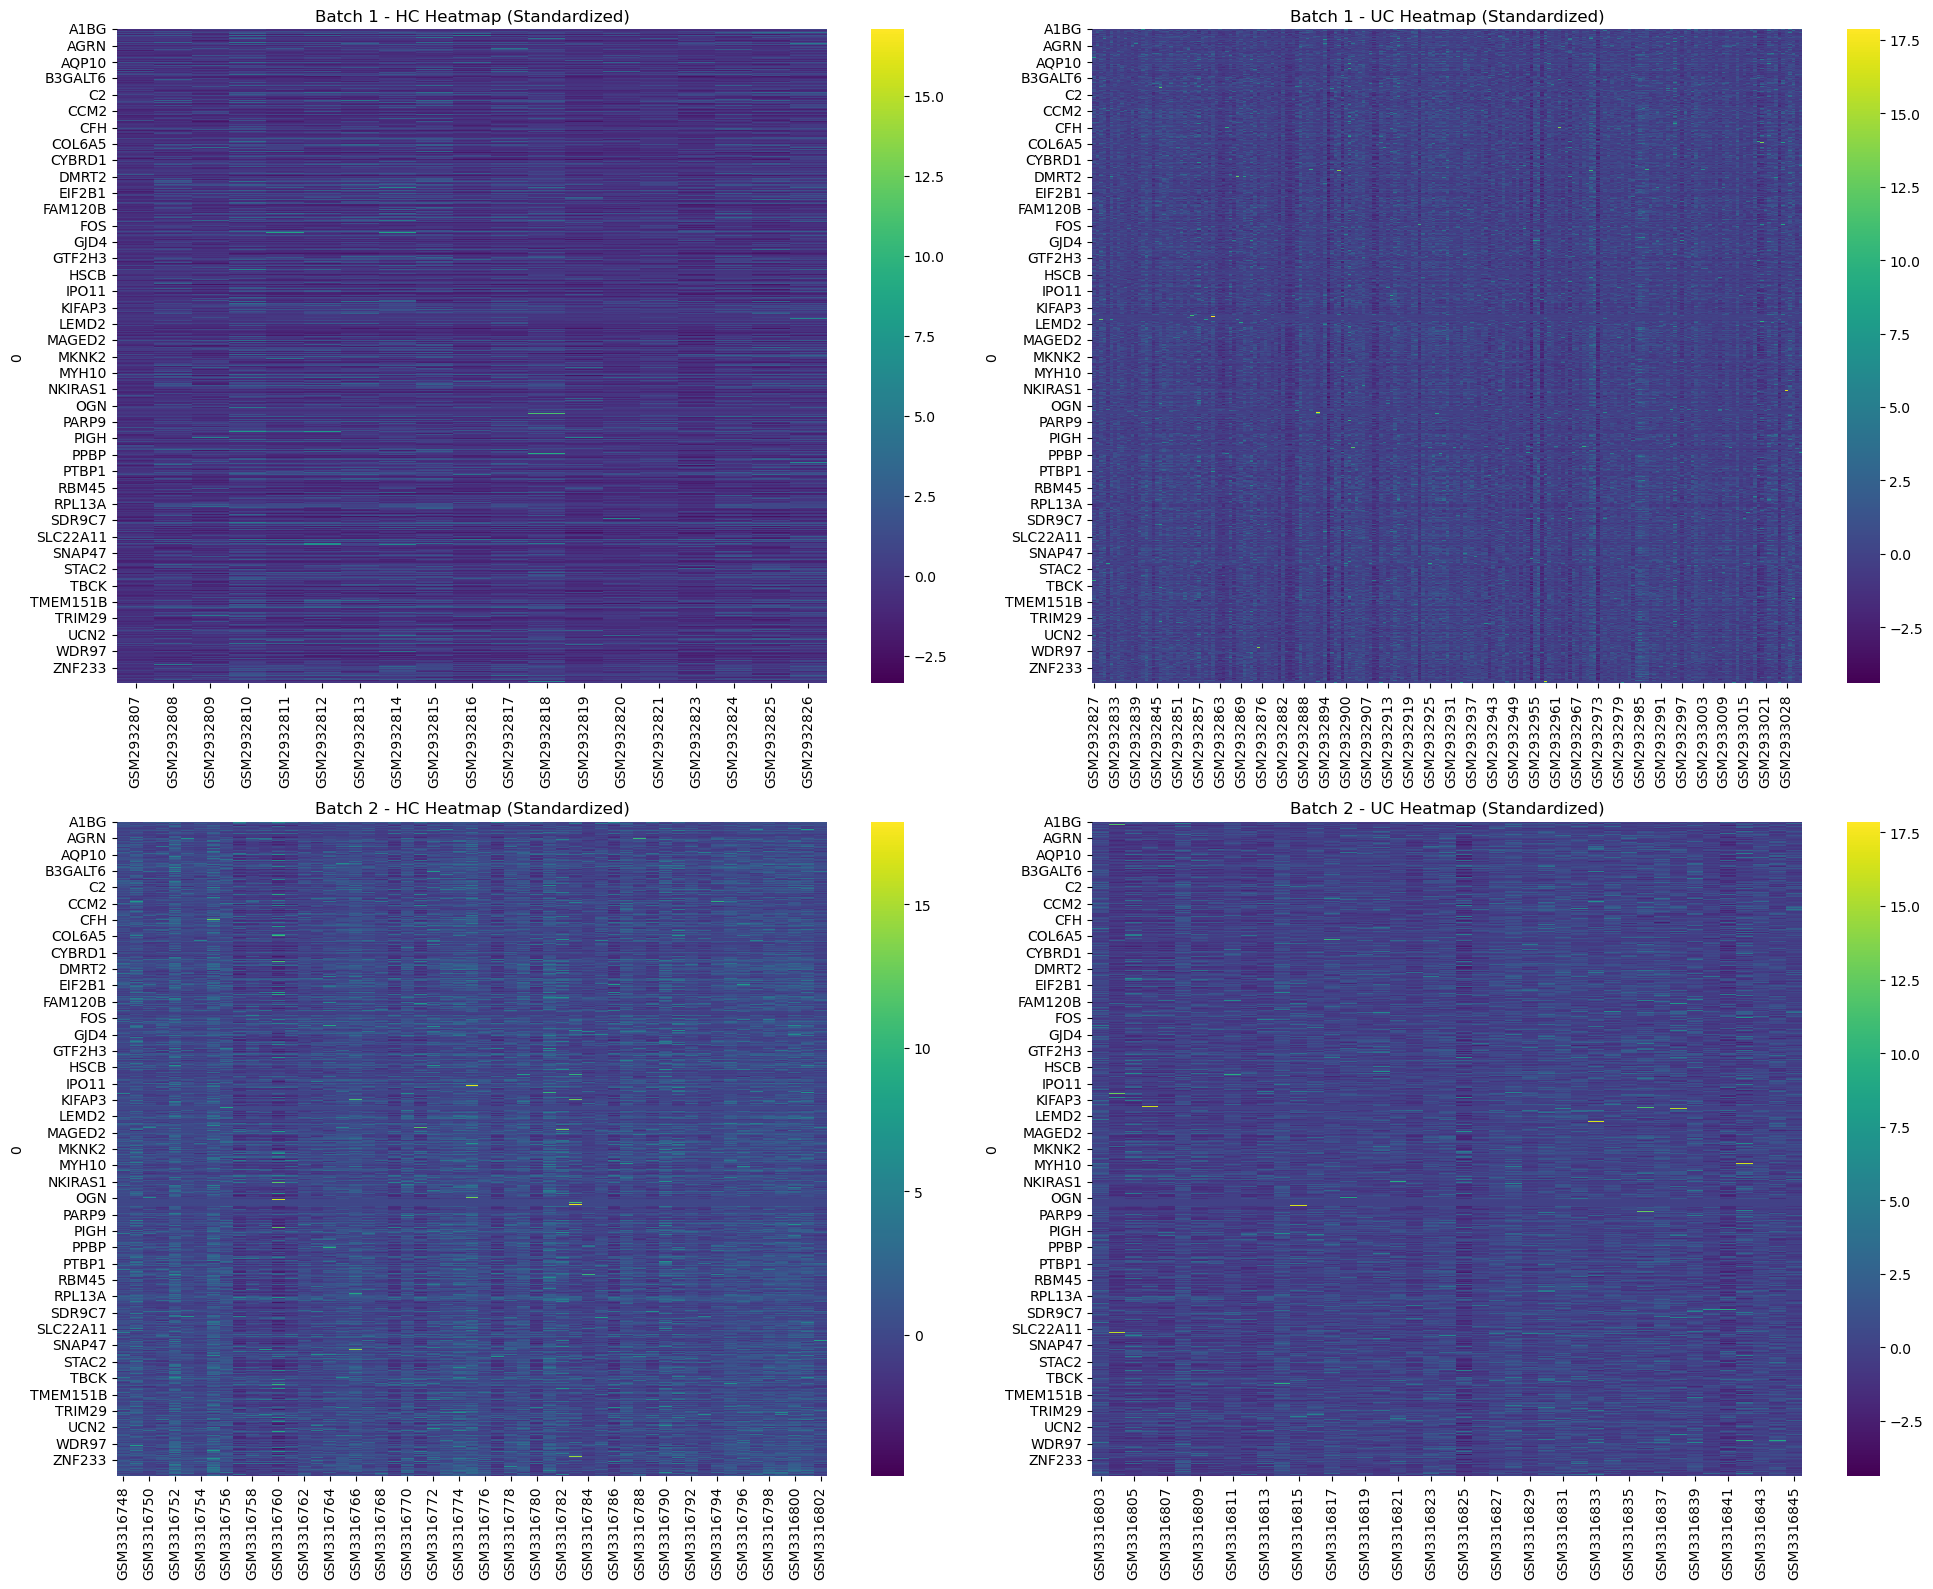

In [23]:
combined_data = pd.concat([batch1_data_before, batch2_data_before], axis=1)
standardized_combined_data = StandardScaler().fit_transform(combined_data.T).T
standardized_combined_data = pd.DataFrame(standardized_combined_data, index=combined_data.index, columns=combined_data.columns)
standardized_batch1_hc_data = standardized_combined_data.loc[:, standardized_combined_data.columns.isin(hc_columns) & standardized_combined_data.columns.str.startswith('GSM2')]
standardized_batch1_uc_data = standardized_combined_data.loc[:, standardized_combined_data.columns.isin(uc_columns) & standardized_combined_data.columns.str.startswith('GSM2')]
standardized_batch2_hc_data = standardized_combined_data.loc[:, standardized_combined_data.columns.isin(hc_columns) & standardized_combined_data.columns.str.startswith('GSM3')]
standardized_batch2_uc_data = standardized_combined_data.loc[:, standardized_combined_data.columns.isin(uc_columns) & standardized_combined_data.columns.str.startswith('GSM3')]
print("Standardized HC Batch 1 Data shape:", standardized_batch1_hc_data.shape)
print("Standardized UC Batch 1 Data shape:", standardized_batch1_uc_data.shape)
print("Standardized HC Batch 2 Data shape:", standardized_batch2_hc_data.shape)
print("Standardized UC Batch 2 Data shape:", standardized_batch2_uc_data.shape)

fig, axes = plt.subplots(2, 2, figsize=(20, 16))
sns.heatmap(standardized_batch1_hc_data, cmap='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Batch 1 - HC Heatmap (Standardized)')
sns.heatmap(standardized_batch1_uc_data, cmap='viridis', ax=axes[0, 1])
axes[0, 1].set_title('Batch 1 - UC Heatmap (Standardized)')
sns.heatmap(standardized_batch2_hc_data, cmap='viridis', ax=axes[1, 0])
axes[1, 0].set_title('Batch 2 - HC Heatmap (Standardized)')
sns.heatmap(standardized_batch2_uc_data, cmap='viridis', ax=axes[1, 1])
axes[1, 1].set_title('Batch 2 - UC Heatmap (Standardized)')
plt.tight_layout()
plt.show()

Standardized HC Data shape: (16542, 74)
Standardized UC Data shape: (16542, 246)


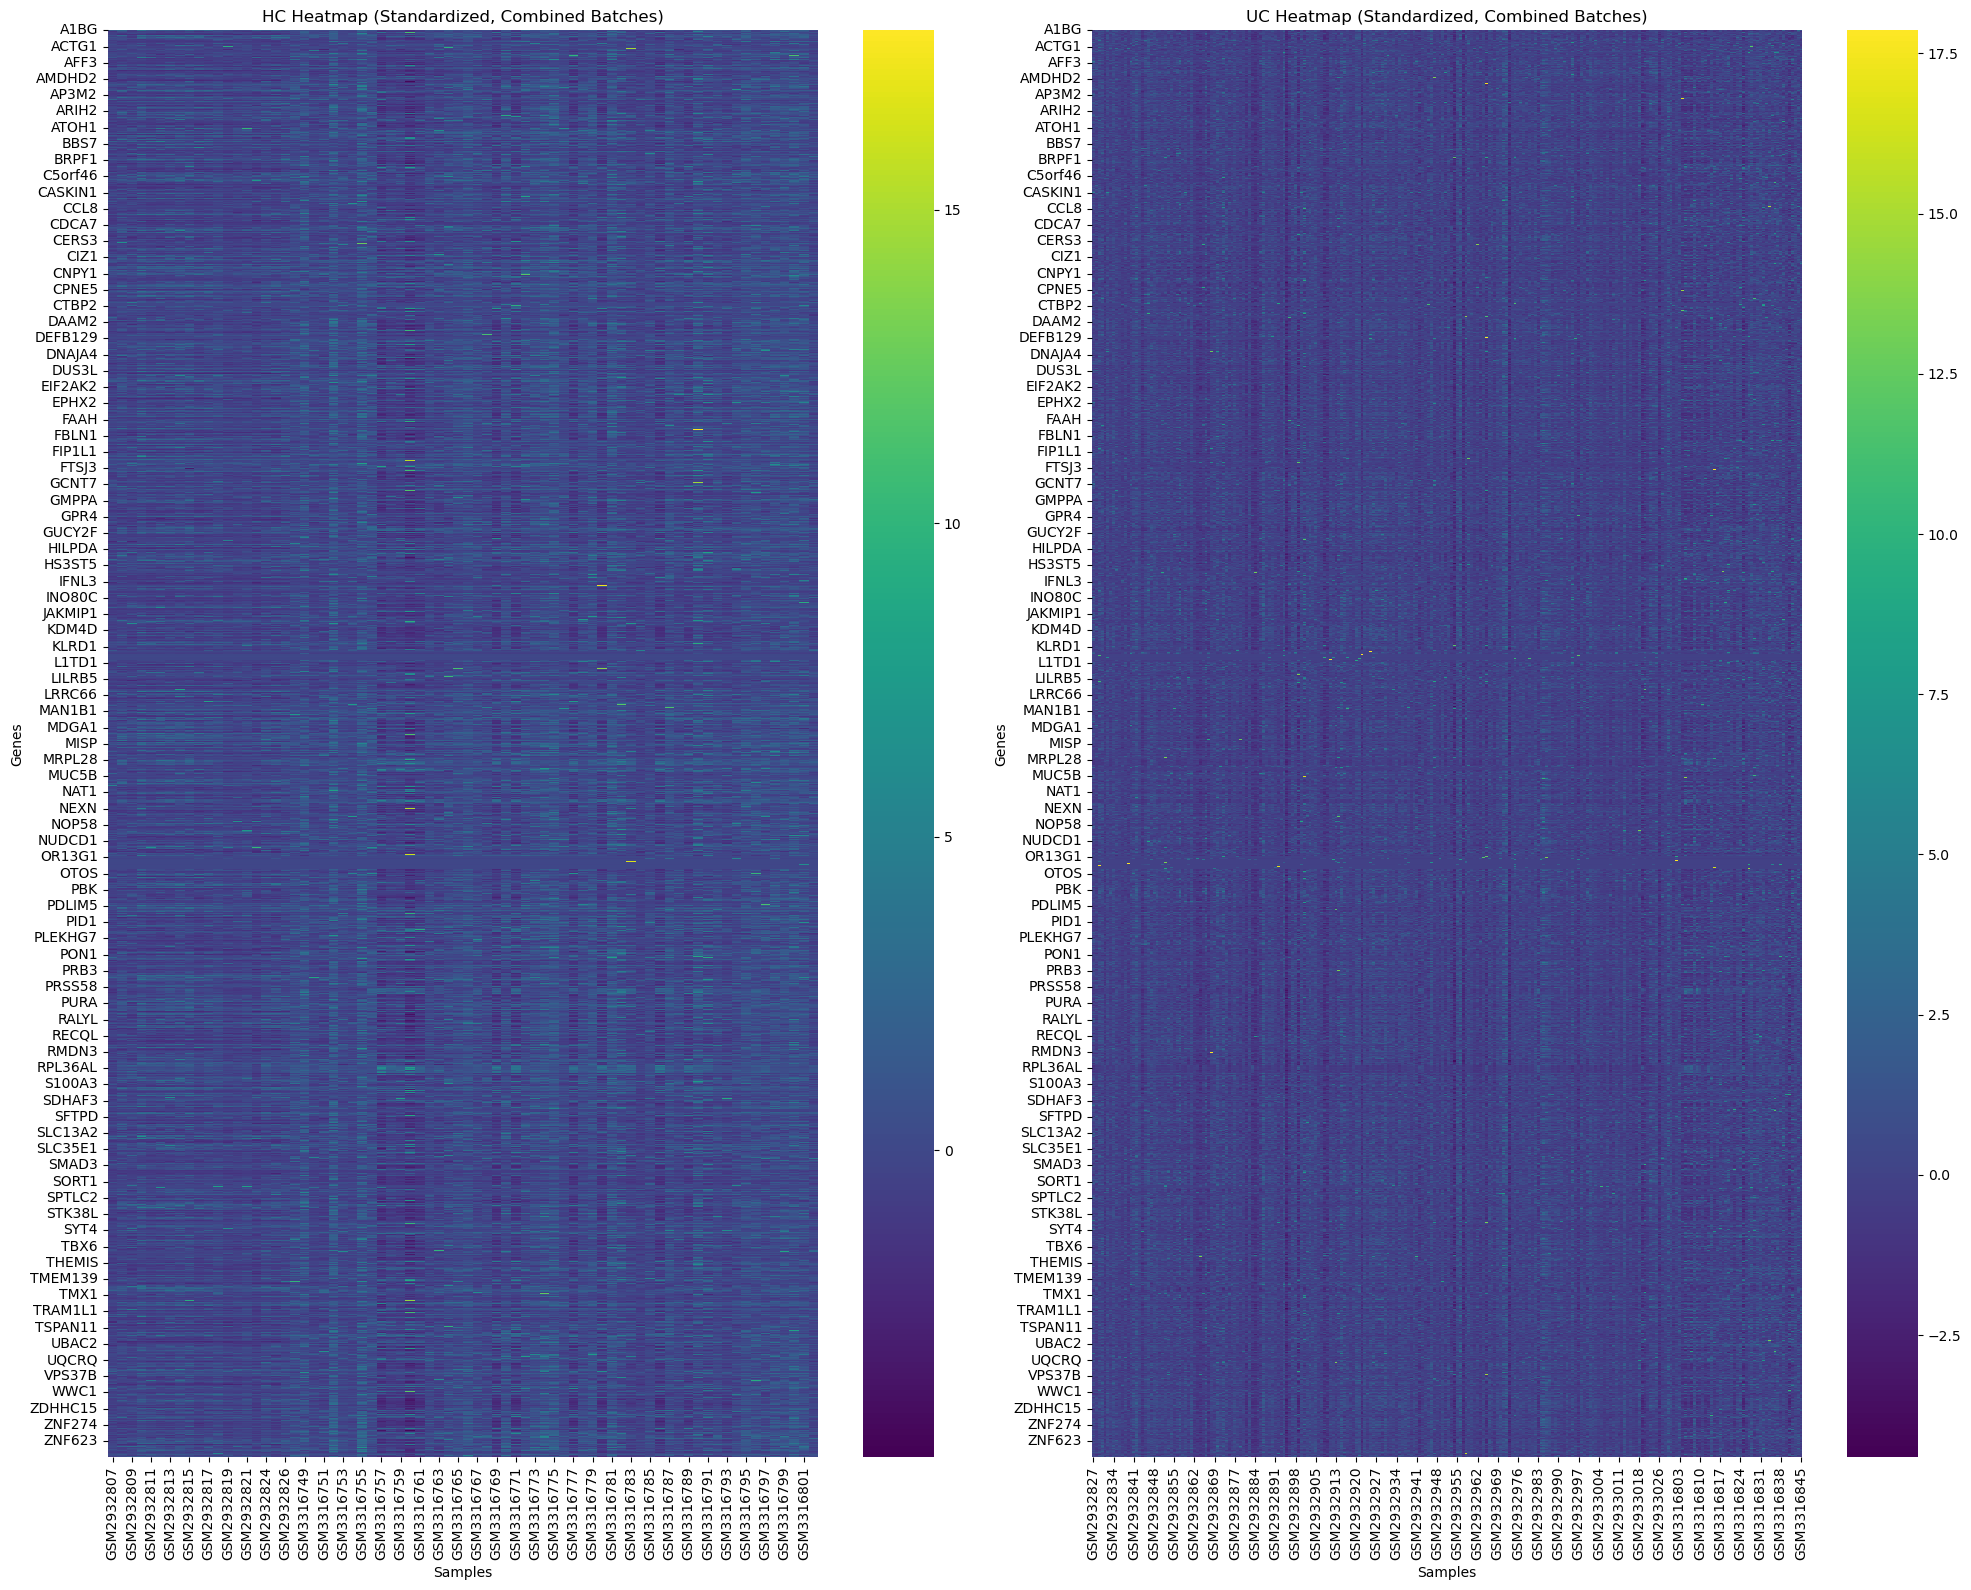

In [22]:
standardized_hc_data = standardized_combined_data.loc[:, standardized_combined_data.columns.isin(hc_columns)]
standardized_uc_data = standardized_combined_data.loc[:, standardized_combined_data.columns.isin(uc_columns)]
print("Standardized HC Data shape:", standardized_hc_data.shape)
print("Standardized UC Data shape:", standardized_uc_data.shape)

# 绘制不区分批次的 HC 和 UC 热图
fig, axes = plt.subplots(1, 2, figsize=(20, 16))
sns.heatmap(standardized_hc_data, cmap='viridis', ax=axes[0])
axes[0].set_title('HC Heatmap (Standardized, Combined Batches)')
axes[0].set_xlabel('Samples')
axes[0].set_ylabel('Genes')
sns.heatmap(standardized_uc_data, cmap='viridis', ax=axes[1])
axes[1].set_title('UC Heatmap (Standardized, Combined Batches)')
axes[1].set_xlabel('Samples')
axes[1].set_ylabel('Genes')
plt.tight_layout()
plt.show()

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
mean_hc_batch1 = batch1_hc_data.mean(axis=1)
mean_uc_batch1 = batch1_uc_data.mean(axis=1)
mean_hc_batch2 = batch2_hc_data.mean(axis=1)
mean_uc_batch2 = batch2_uc_data.mean(axis=1)
diff_expr_batch1 = mean_uc_batch1 - mean_hc_batch1
diff_expr_batch2 = mean_uc_batch2 - mean_hc_batch2
diff_expr_batch1_df = pd.DataFrame(diff_expr_batch1, columns=['Differential Expression'])
diff_expr_batch2_df = pd.DataFrame(diff_expr_batch2, columns=['Differential Expression'])
significant_genes_batch1 = diff_expr_batch1_df[(diff_expr_batch1_df['Differential Expression'] > vmax) | 
                                               (diff_expr_batch1_df['Differential Expression'] < vmin)].index.tolist()

significant_genes_batch2 = diff_expr_batch2_df[(diff_expr_batch2_df['Differential Expression'] > vmax) | 
                                               (diff_expr_batch2_df['Differential Expression'] < vmin)].index.tolist()
print("Batch 1 - Significant Genes (Differential Expression > 50 or < -50):")
print(significant_genes_batch1)
print("\nBatch 2 - Significant Genes (Differential Expression > 50 or < -50):")
print(significant_genes_batch2)

Batch 1 - Significant Genes (Differential Expression > 50 or < -50):
['A2M', 'ACAA2', 'ACADVL', 'ADAMDEC1', 'ADH1C', 'AGR2', 'AGR3', 'AHCYL2', 'ANKRD10', 'ANXA1', 'ANXA2', 'ANXA5', 'AOC1', 'APLP2', 'APP', 'AQP8', 'ARHGDIB', 'ARPC1B', 'ASS1', 'ATF4', 'ATP1A1', 'ATP1B3', 'B3GNT7', 'BACE2', 'BLOC1S1', 'BSG', 'BTF3', 'C15orf48', 'C1QA', 'C1QC', 'C1S', 'C3', 'CA12', 'CA1', 'CA2', 'CA4', 'CALM1', 'CALM2', 'CALR', 'CAMK2N1', 'CANT1', 'CAPNS1', 'CASP1', 'CASP5', 'CCL19', 'CCL20', 'CCL21', 'CD164', 'CD177', 'CD24', 'CD44', 'CD53', 'CD55', 'CD59', 'CD63', 'CD68', 'CD74', 'CD79A', 'CD9', 'CDC42EP5', 'CDH17', 'CDH1', 'CDHR5', 'CDX1', 'CDX2', 'CEACAM1', 'CEACAM5', 'CEACAM6', 'CEACAM7', 'CES2', 'CFB', 'CFL1', 'CHCHD10', 'CHCHD2', 'CHGA', 'CHI3L1', 'CHMP4B', 'CHP2', 'CKB', 'CLCA1', 'CLDN3', 'CLDN4', 'CLDN7', 'CLDN8', 'CLIC1', 'CLU', 'CMBL', 'COL1A1', 'COL1A2', 'COL3A1', 'COL6A1', 'COL6A2', 'CORO1A', 'COX4I1', 'COX5A', 'COX5B', 'COX6A1', 'COX6C', 'COX7A2', 'COX7C', 'COX8A', 'CRIP1', 'CST3', 'CTSA', 'C

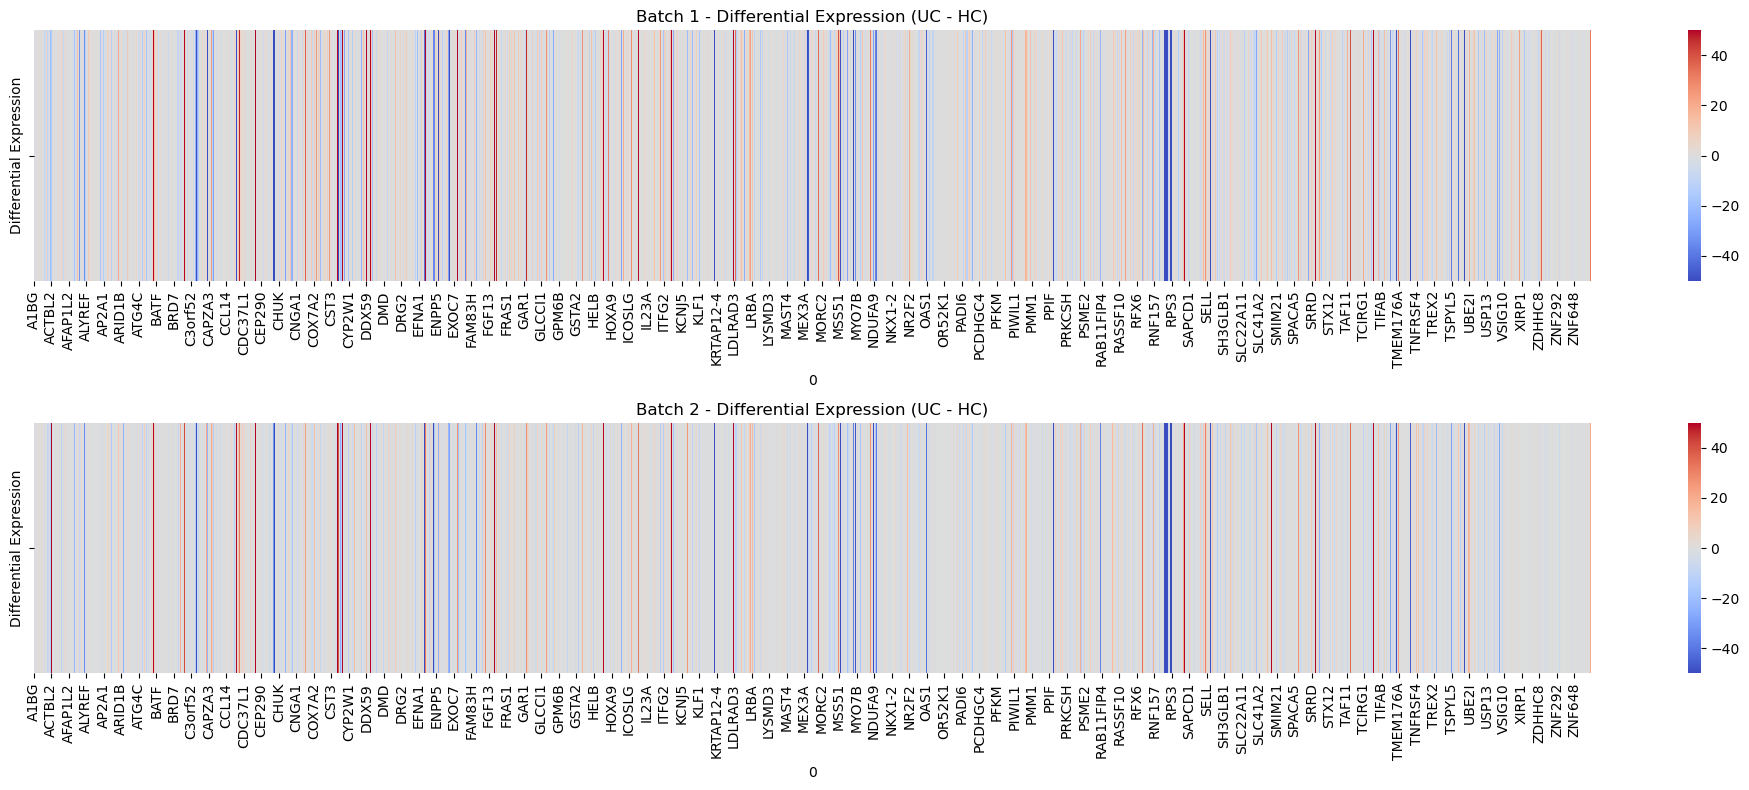

In [28]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
vmin = -50
vmax = 50
# Batch 1
sns.heatmap(diff_expr_batch1_df.T, cmap='coolwarm', center=0, vmin=vmin, vmax=vmax, ax=axes[0])
axes[0].set_title('Batch 1 - Differential Expression (UC - HC)')
# Batch 2
sns.heatmap(diff_expr_batch2_df.T, cmap='coolwarm', center=0, vmin=vmin, vmax=vmax, ax=axes[1])
axes[1].set_title('Batch 2 - Differential Expression (UC - HC)')
plt.tight_layout()
plt.show()

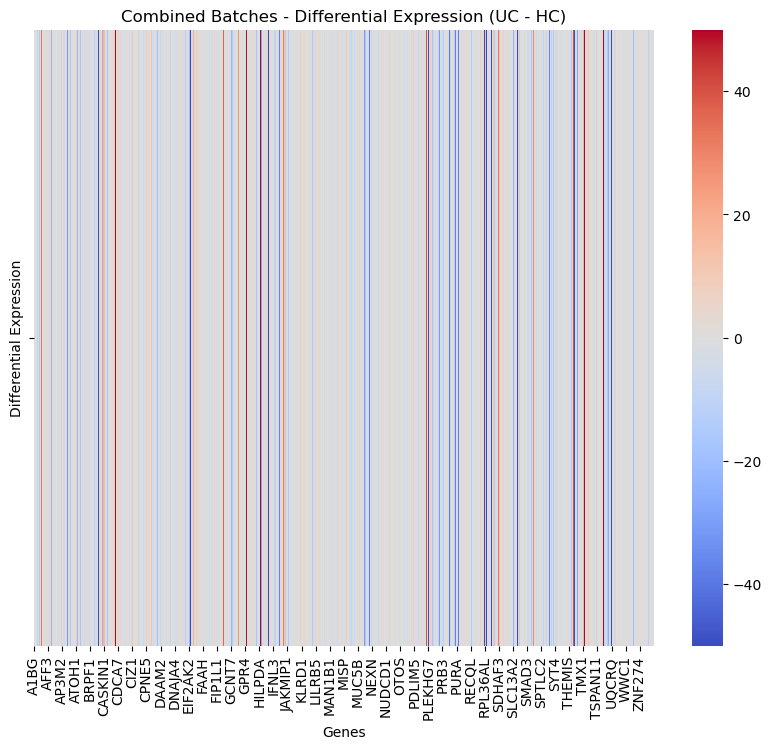

In [27]:
combined_hc_data = pd.concat([batch1_hc_data, batch2_hc_data], axis=1)
combined_uc_data = pd.concat([batch1_uc_data, batch2_uc_data], axis=1)
mean_hc_combined = combined_hc_data.mean(axis=1)
mean_uc_combined = combined_uc_data.mean(axis=1)
diff_expr_combined = mean_uc_combined - mean_hc_combined
diff_expr_combined_df = pd.DataFrame(diff_expr_combined, columns=['Differential Expression'])
vmin = -50
vmax = 50
plt.figure(figsize=(10, 8))
sns.heatmap(diff_expr_combined_df.T, cmap='coolwarm', center=0, vmin=vmin, vmax=vmax)
plt.title('Combined Batches - Differential Expression (UC - HC)')
plt.xlabel('Genes')
plt.show()

In [8]:
# 计算差异表达值的平均值和标准差
mean_diff_expr_batch1 = diff_expr_batch1.mean()
std_diff_expr_batch1 = diff_expr_batch1.std()

mean_diff_expr_batch2 = diff_expr_batch2.mean()
std_diff_expr_batch2 = diff_expr_batch2.std()

# threshold：mean加减2倍标准差为例
threshold_batch1_upper = mean_diff_expr_batch1 + 2 * std_diff_expr_batch1
threshold_batch1_lower = mean_diff_expr_batch1 - 2 * std_diff_expr_batch1

threshold_batch2_upper = mean_diff_expr_batch2 + 2 * std_diff_expr_batch2
threshold_batch2_lower = mean_diff_expr_batch2 - 2 * std_diff_expr_batch2

significant_genes_batch1 = diff_expr_batch1_df[(diff_expr_batch1 > threshold_batch1_upper) | 
                                               (diff_expr_batch1 < threshold_batch1_lower)]

significant_genes_batch2 = diff_expr_batch2_df[(diff_expr_batch2 > threshold_batch2_upper) | 
                                               (diff_expr_batch2 < threshold_batch2_lower)]

# 打印出这些基因的名称和对应的差异表达值
print("Batch 1 - Significant Genes (Auto-threshold):")
print(significant_genes_batch1)
significant_genes_batch1.to_csv('/Users/martinli/Desktop/SZ/significant_genes_batch1.csv')

print("\nBatch 2 - Significant Genes (Auto-threshold):")
print(significant_genes_batch2)
significant_genes_batch2.to_csv('/Users/martinli/Desktop/SZ/significant_genes_batch2.csv')

Batch 1 - Significant Genes (Auto-threshold):
         Differential Expression
0                               
ADH1C                -176.983482
AGR2                  190.973586
ANXA2                 189.090354
AQP8                 -496.812189
ASS1                  413.950235
...                          ...
UGT2B17              -192.891613
UQCRQ                -151.918302
VSIG2                -153.128731
XBP1                  196.576074
ZG16                 -250.552083

[190 rows x 1 columns]

Batch 2 - Significant Genes (Auto-threshold):
          Differential Expression
0                                
ACADVL                -130.539955
ADAMDEC1              -256.027358
AGR2                   168.926727
ANXA2                  170.430765
AQP8                  -408.813416
...                           ...
TXNDC5                 122.389221
TXN                   -139.918589
UBB                   -159.646285
XBP1                   206.602866
ZG16                  -219.148940

[195 rows x

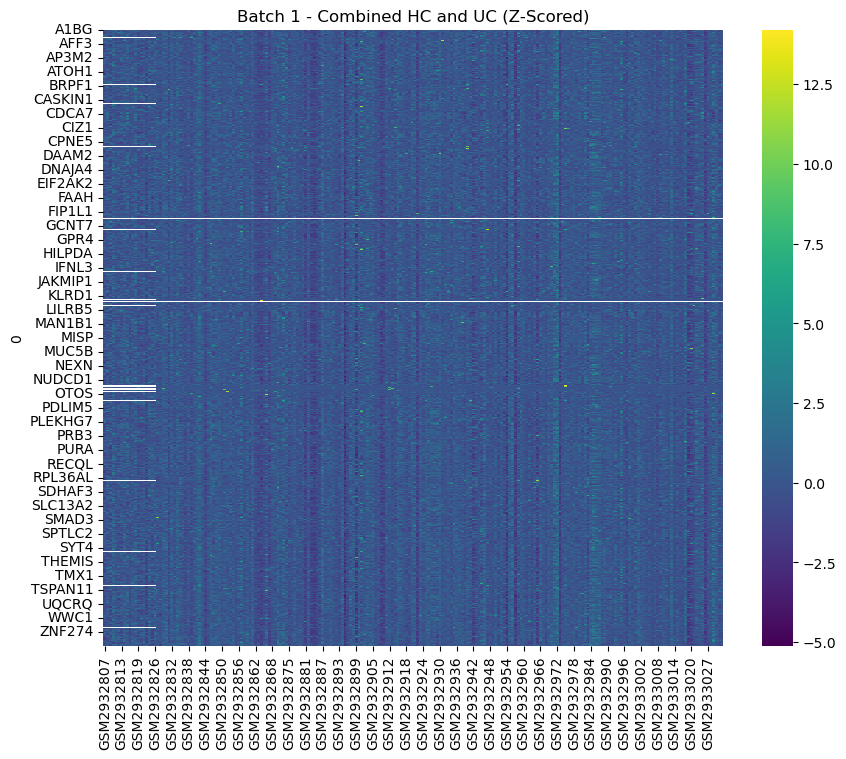

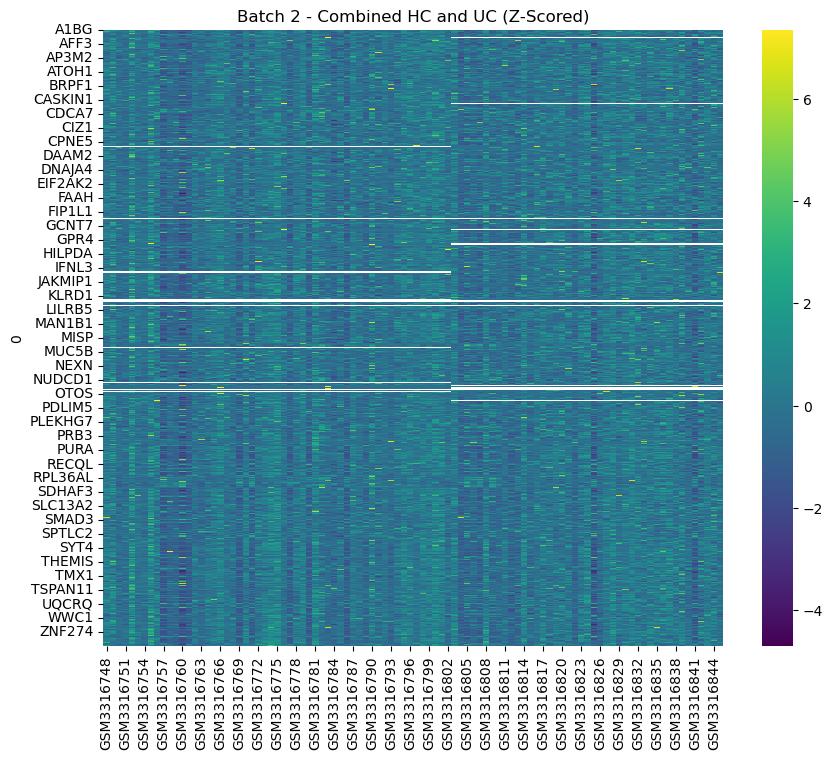

In [9]:
from scipy.stats import zscore

# z-score
zscored_hc_data_batch1 = batch1_hc_data.apply(zscore, axis=1)
zscored_uc_data_batch1 = batch1_uc_data.apply(zscore, axis=1)
zscored_hc_data_batch2 = batch2_hc_data.apply(zscore, axis=1)
zscored_uc_data_batch2 = batch2_uc_data.apply(zscore, axis=1)

# Combine the z-scored data
combined_batch1_zscored = pd.concat([zscored_hc_data_batch1, zscored_uc_data_batch1], axis=1)
combined_batch2_zscored = pd.concat([zscored_hc_data_batch2, zscored_uc_data_batch2], axis=1)

# Plot the z-scored heatmaps
plt.figure(figsize=(10, 8))
sns.heatmap(combined_batch1_zscored, cmap='viridis')
plt.title('Batch 1 - Combined HC and UC (Z-Scored)')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(combined_batch2_zscored, cmap='viridis')
plt.title('Batch 2 - Combined HC and UC (Z-Scored)')
plt.show()

/Users/martinli/miniconda3/envs/bayesian/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log1p
  result = func(self.values, **kwargs)


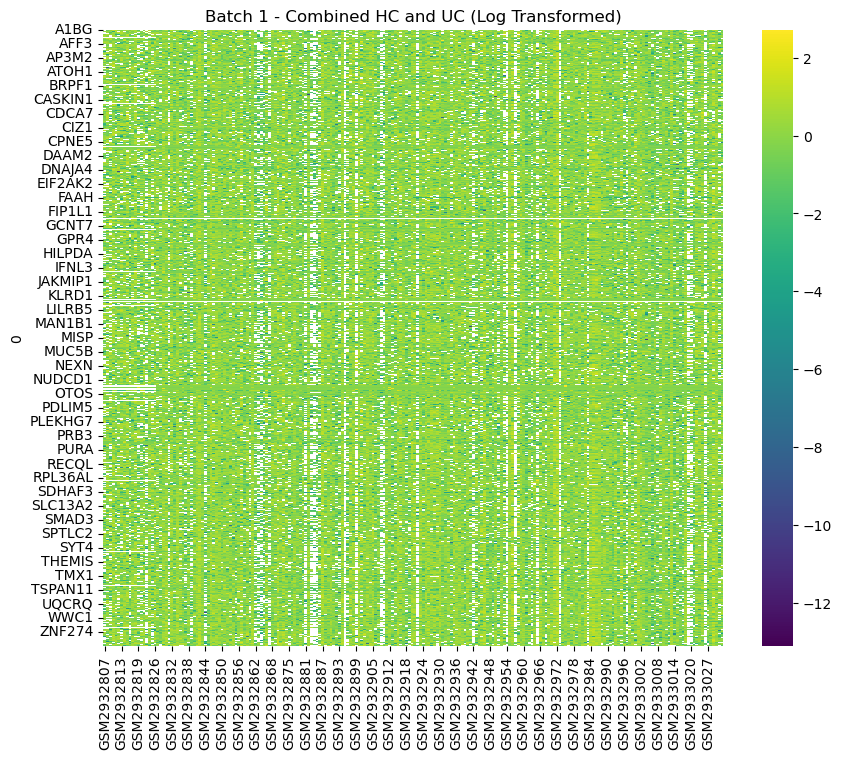

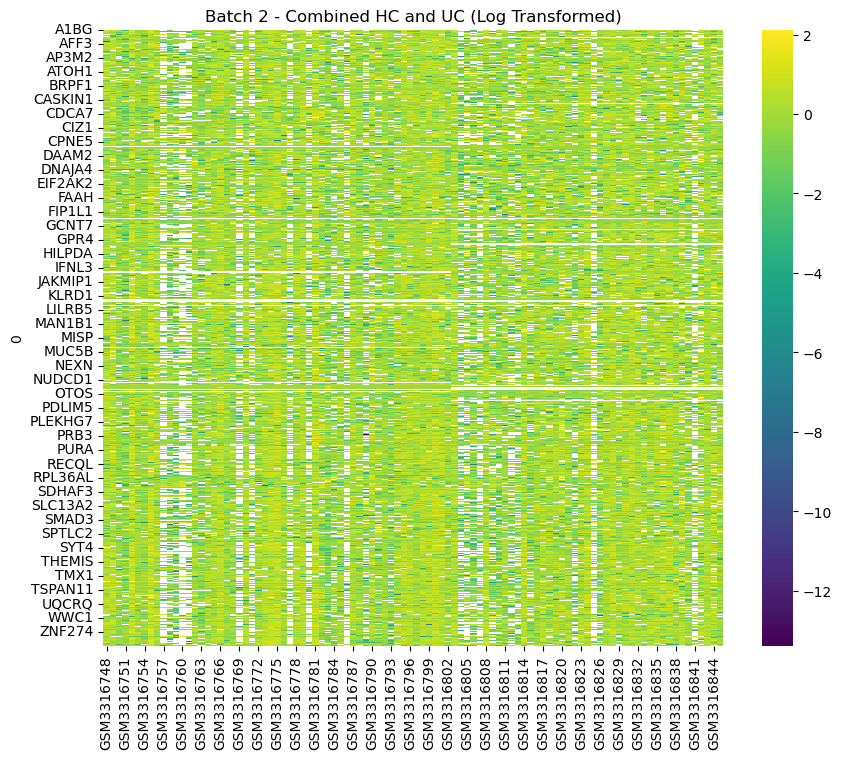

In [10]:
log_transformed_hc_data = np.log1p(combined_batch1_zscored)
log_transformed_uc_data = np.log1p(combined_batch2_zscored)

plt.figure(figsize=(10, 8))
sns.heatmap(log_transformed_hc_data, cmap='viridis')
plt.title('Batch 1 - Combined HC and UC (Log Transformed)')
plt.show()

plt.figure(figsize=(10, 8))
sns.heatmap(log_transformed_uc_data, cmap='viridis')
plt.title('Batch 2 - Combined HC and UC (Log Transformed)')
plt.show()